# Demo RNA Multi-Perceptrón Backpropagation usando Keras para procesar las imágenes de ANIMALES e identificar el tipo correspondiente

1) Cargar librerías:

In [41]:
from __future__ import absolute_import, division, print_function, unicode_literals

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Definir los parámetros:

In [42]:
# tamaño de las imágenes
IMAGE_SHAPE = (32, 32, 3)

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# define tamaño de datos de salida (las clases están codificadas en un único número)
num_outputs = 1 

# cantidad de neuronas ocultas 
hidden_layers = [ 392, 84, 56, 32 ] 

# cantidad de épocas del entrenamiento
cantEpocas = 500

print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers, num_outputs," ] ")

Configuración de RNA MLP Backpropagation definida: [ 3072 [392, 84, 56, 32] 1  ] 


3) Montar el Drive:

In [43]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demo ANIMALES' 
imagPath_train = path + '/imagenes/train' 
imagPath_test = path + '/imagenes/test' 

Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo:

> Para Entrenamiento: 
- Clases cargadas:  42
- Imágenes cargadas:  42
- Ejemplo  invertebrado   (32, 32, 3) : 


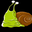



> Para Prueba: 
- Clases cargadas:  18
- Imágenes cargadas:  18
- Ejemplo  mamifero   (32, 32, 3) : 


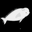

In [44]:
# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:
            
            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)
            
            # ajusta el tamaño
            if IMAGE_SHAPE[2]==1:              
              tipoImage = 'L'
            else:                
              tipoImage = 'RGB'
            imag = imag.convert(tipoImage)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
            
            # transforma a un vector de nros
            arImag = np.array(imag)
            
            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag )
  return classes_ori, images_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )


> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (42, 3072)
 - y_train (cant):  42


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (18, 3072)
 - y_test (cant):  18


> Para Ambos: 
 - dictMapeo:  {'insecto': 0, 'pez': 1, 'invertebrado': 2, 'mamifero': 3, 'reptil': 4, 'ave': 5}
 - clases_map:  ['insecto', 'pez', 'invertebrado', 'mamifero', 'reptil', 'ave']

 - Imagen reconstruida de  invertebrado ( 2 )


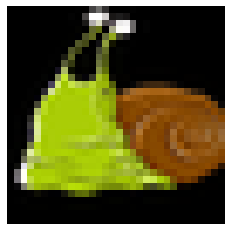

In [45]:
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))  
  return np.array(auxiAr)

# define función auxiliar para preparar lista de clases 
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  return np.array(y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, dictMapeo = prepare_clasesList(classes_train)
y_test, _ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]], "(", y_train[0], ")")
  plot_image(x_train[0])

5) Establecer el modelo para la RNA:

Modelo creado con  6  capas:
Model: "RNA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidd_1 (Dense)               (None, 392)               1204616   
_________________________________________________________________
hidd_2 (Dense)               (None, 84)                33012     
_________________________________________________________________
hidd_3 (Dense)               (None, 56)                4760      
_________________________________________________________________
hidd_4 (Dense)               (None, 32)                1824      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 1,244,245
Trainable params: 1,244,245
Non-trainable params: 0
________________________

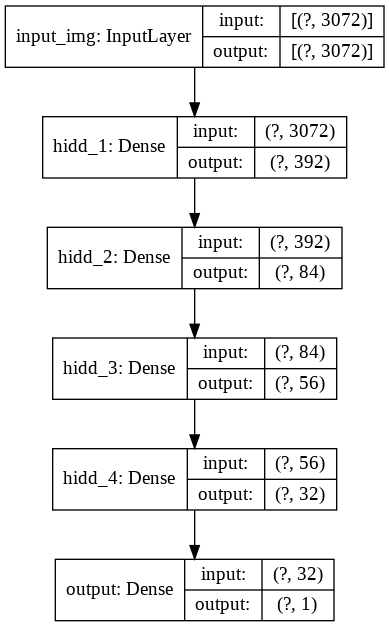

In [46]:
# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'hidd_'
auxId = 1 
for num_hid in hidden_layers:  
    
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = Dense(num_hid, name=auxlayerName)(eachLay) # capas ocultas

output_img_Lay = Dense(num_outputs, activation=None, name='output')(eachLay) # capa de salida

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


6) Entrenar el modelo de la RNA:

In [47]:
# lleva a cabo el entrenamiento
model.fit(x_train, y_train,
                epochs = cantEpocas, 
                batch_size = 5 ) 

Epoch 1/500
9/9 [==============================] - 0s 11ms/step - loss: 763.8945 - accuracy: 0.1667
Epoch 2/500
9/9 [==============================] - 0s 11ms/step - loss: 9.6941 - accuracy: 0.0714
Epoch 3/500
9/9 [==============================] - 0s 11ms/step - loss: 9.8028 - accuracy: 0.1667
Epoch 4/500
9/9 [==============================] - 0s 11ms/step - loss: 41.3437 - accuracy: 0.1667
Epoch 5/500
9/9 [==============================] - 0s 10ms/step - loss: 2.2609 - accuracy: 0.2619
Epoch 6/500
9/9 [==============================] - 0s 11ms/step - loss: 8.6153 - accuracy: 0.1905
Epoch 7/500
9/9 [==============================] - 0s 10ms/step - loss: 7.6358 - accuracy: 0.2143
Epoch 8/500
9/9 [==============================] - 0s 11ms/step - loss: 3.7577 - accuracy: 0.1667
Epoch 9/500
9/9 [==============================] - 0s 10ms/step - loss: 6.4203 - accuracy: 0.2143
Epoch 10/500
9/9 [==============================] - 0s 10ms/step - loss: 12.4909 - accuracy: 0.0952
Epoch 11/500
9/

*** Resultados con datos de Entrenamiento: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 Reporte de Clasificación: 
              precision    recall  f1-score   support

         ave       1.00      1.00      1.00         7
     insecto       1.00      1.00      1.00         7
invertebrado       1.00      1.00      1.00         7
    mamifero       1.00      1.00      1.00         7
         pez       1.00      1.00      1.00         7
      reptil       1.00      1.00      1.00         7

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42


Matriz de Confusión: 
                p:insecto  p:pez  p:invertebrado  p:mamifero  p:reptil  p:ave
r:insecto               7      0               0           0         0      0
r:pez                   0      7               0           0         0      0
r:invertebrado          0      0               7           0         0      0
r:mamifero              0      0               0           7         0      0
r:reptil       

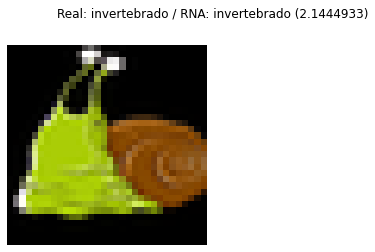

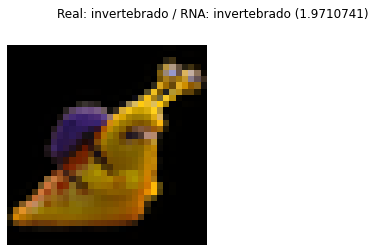

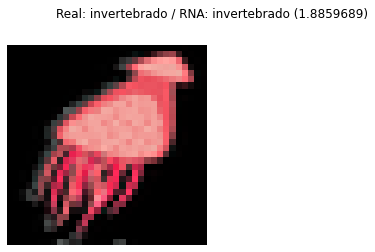

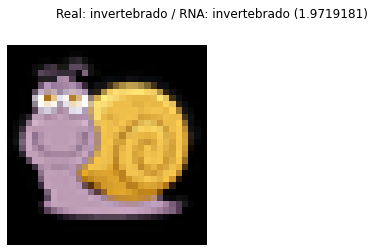

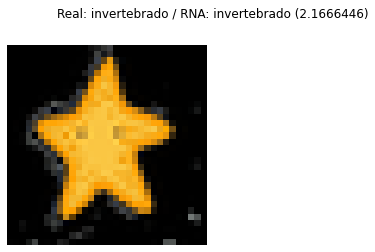

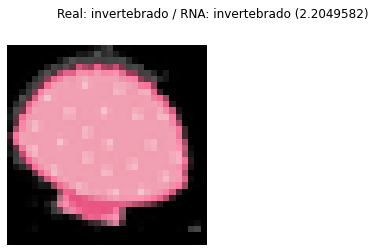

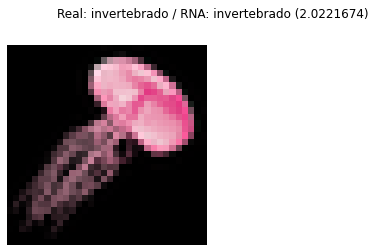

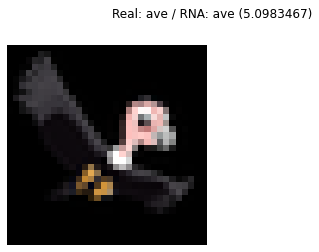

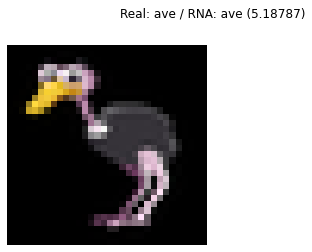

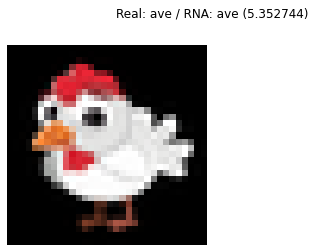

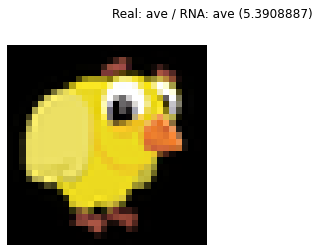

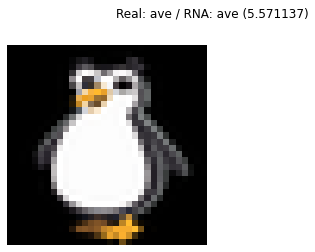

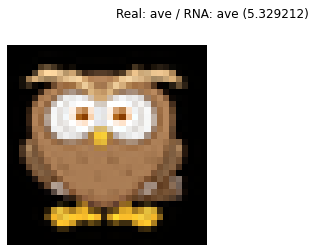

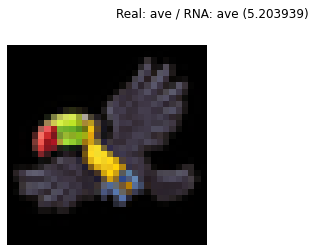

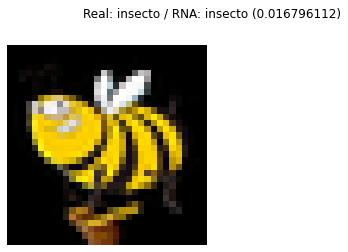

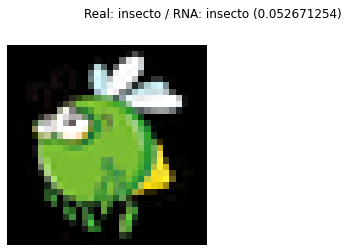

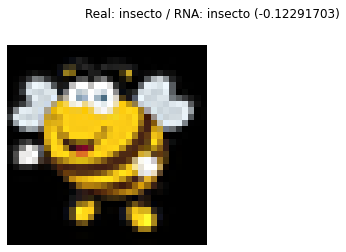

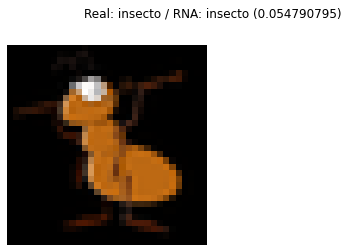

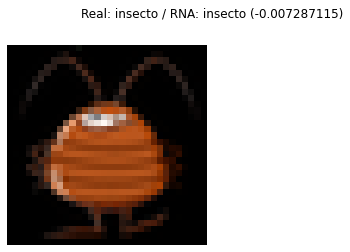

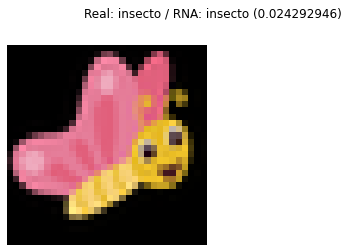

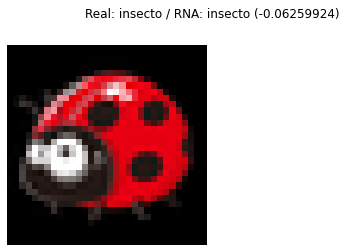

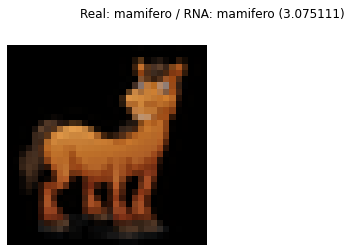

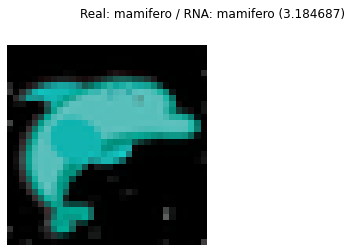

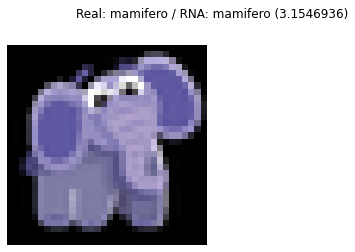

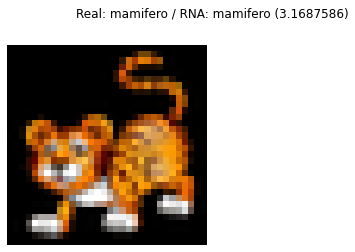

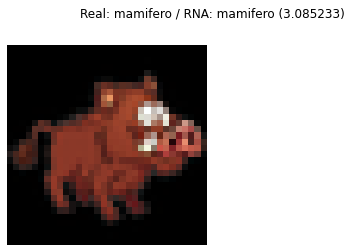

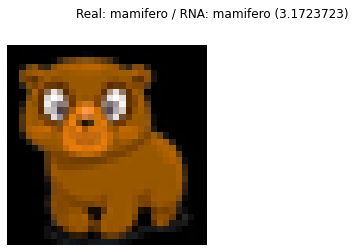

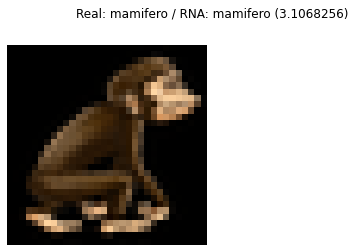

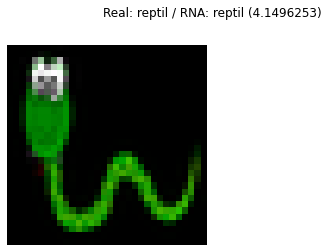

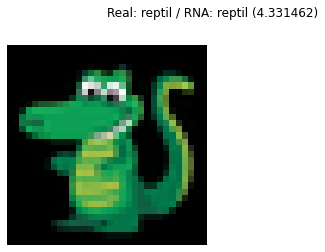

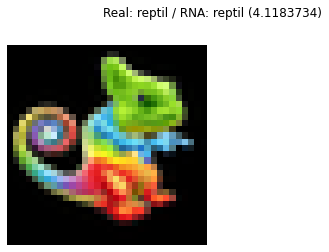

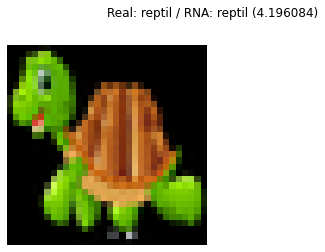

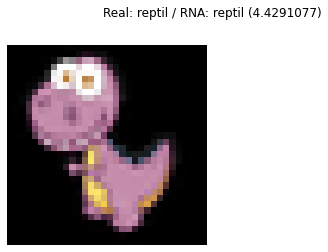

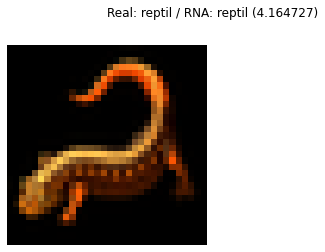

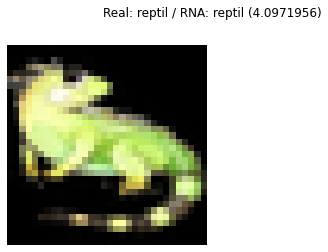

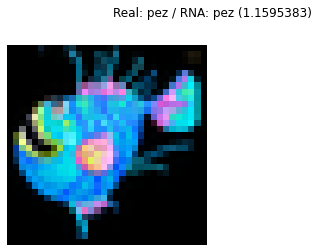

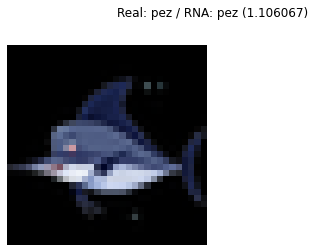

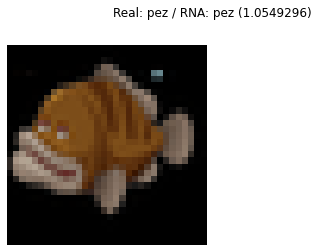

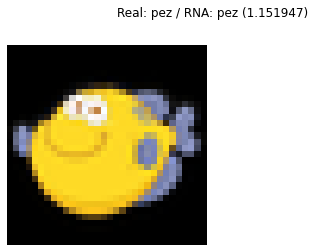

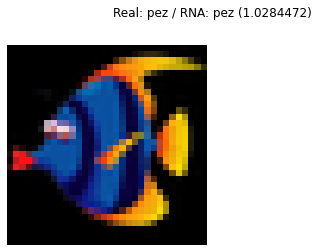

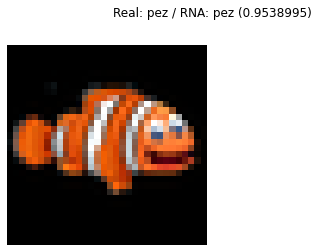

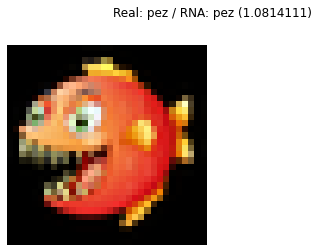

In [48]:
# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 
        idclPred = predClass[i][0]

        ## determina clase predecida de acuerdo al umbral de clasificación
        idclPredRnd = int(idclPred)
        if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / RNA: ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

        # muestra comparación con la imagen
        fig = plt.figure()
        fig.suptitle( strTitulo )
        ax1 = fig.add_subplot(121)
        plot_image( x[i] )
        
        plt.tight_layout()
        fig = plt.gcf()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

    print("\n>Resultados: ")


# prueba con los datos de prueba
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, clases_map)

7) Evaluar el modelo de la RNA entrenado usando las imágenes de prueba:

1/1 [==============================] - 0s 1ms/step - loss: 3.6756 - accuracy: 0.1111

>Evaluación del Modelo: 
    - Error:  3.675571918487549
    - Exactitud:  11.11111119389534




*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
                   precision    recall  f1-score   support

CLASE 6 INVÁLIDA!       0.00      0.00      0.00         0
              ave       0.00      0.00      0.00         3
          insecto       0.00      0.00      0.00         3
     invertebrado       0.00      0.00      0.00         3
         mamifero       0.20      0.33      0.25         3
              pez       0.00      0.00      0.00         3
           reptil       0.20      0.33      0.25         3

         accuracy                           0.11        18
        macro avg       0.06      0.10      0.07        18
     weighted avg       0.07      0.11      0.08        18


Matriz de Confusión: 
                p:insecto  p:pez  p:invertebrado  p:mamifero  p:repti

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


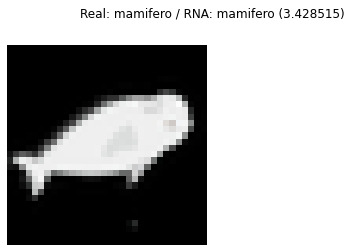

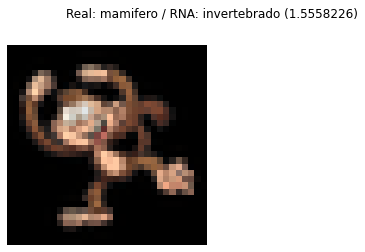

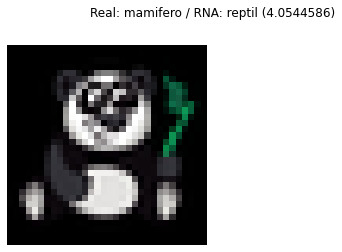

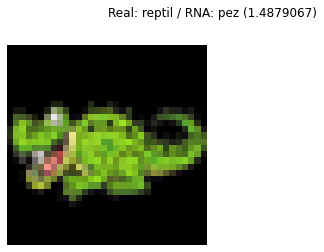

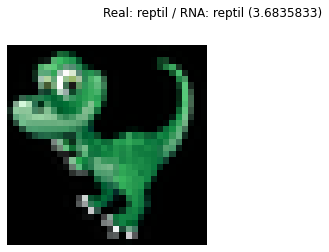

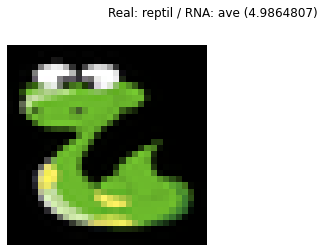

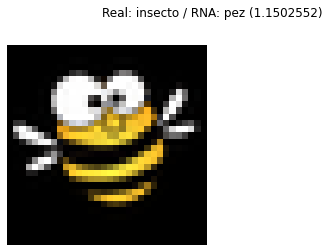

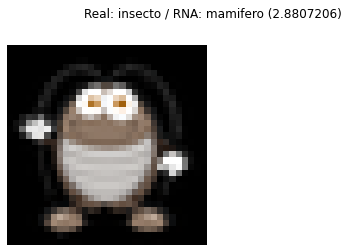

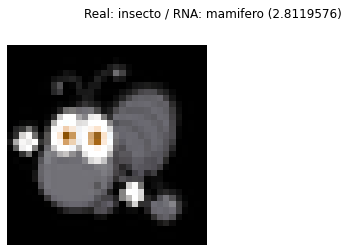

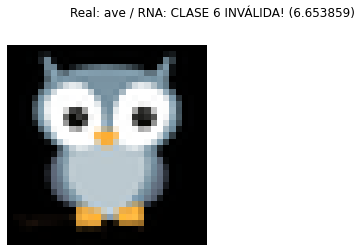

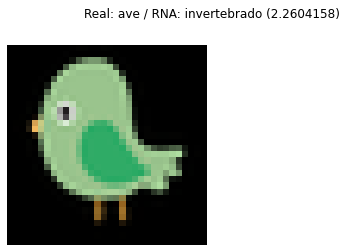

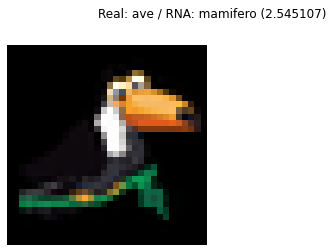

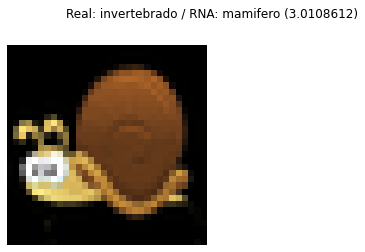

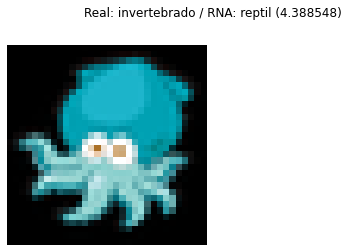

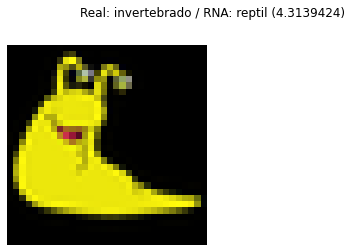

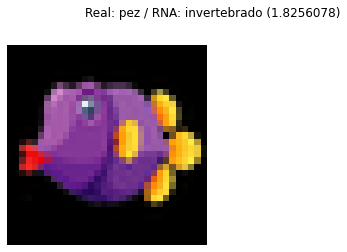

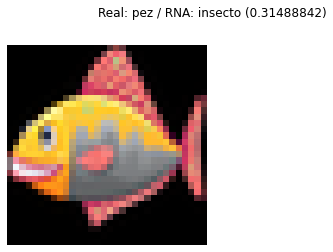

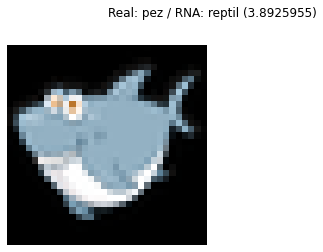

In [49]:
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, y_test)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos de Entrenamiento: ")
probarModelo(x_test, y_test, clases_map)